In [1]:
import sounddevice as sd
import numpy as np
import python_speech_features
from tflite_runtime.interpreter import Interpreter
import matplotlib.pyplot as plt

model_path = 'smithers_lite.tflite'
clip_length = 1
buffer_length = clip_length / 2
resample_rate = 10000
threshold = 0.5

In [2]:
window = np.int16(np.zeros(int(buffer_length * resample_rate) * 2))

interpreter = Interpreter(model_path)
interpreter.allocate_tensors()
input_details = interpreter.get_input_details()
output_details = interpreter.get_output_details()

In [3]:
# sounddevice callback
def sd_callback(rec, frames, time, status):

    # remove unnecessary dimension
    rec = np.squeeze(rec)

    # sliding window
    window[:len(window)//2] = window[len(window)//2:]
    window[len(window)//2:] = rec

    # calculate mfccs
    mfcc = python_speech_features.base.mfcc(window, samplerate=resample_rate, winstep=0.025, numcep=13, winfunc=np.hanning)
    mfcc = np.int8(mfcc)
    mfcc = mfcc.transpose()

    # set up tensors
    in_tensor = np.float32(mfcc.reshape(1, mfcc.shape[0], mfcc.shape[1], 1))
    interpreter.set_tensor(input_details[0]['index'], in_tensor)
    interpreter.invoke()
    output = interpreter.get_tensor(output_details[0]['index'])
    prediction = output[0][0]

    # if "Hey Smithers" is detected
    if prediction > threshold:
        print('Hey Smithers detected!')

In [4]:
# set up sounddevice stream
with sd.InputStream(channels=1,
                    samplerate=resample_rate,
                    dtype='int16',
                    blocksize=int(resample_rate * buffer_length),
                    callback=sd_callback):
    while True:
        pass

Hey Smithers detected!
Hey Smithers detected!
Hey Smithers detected!
Hey Smithers detected!
Hey Smithers detected!
Hey Smithers detected!
Hey Smithers detected!
Hey Smithers detected!


KeyboardInterrupt: 

<class 'numpy.int16'>


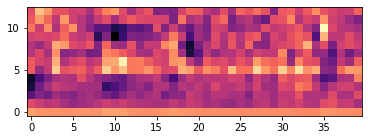

In [ ]:
sd.play(window, resample_rate)
mfccs = python_speech_features.base.mfcc(window, samplerate=resample_rate, winstep=0.025, numcep=13, winfunc=np.hanning)
mfccs = mfccs.transpose()
print(type(window[0]))

fig = plt.figure()
plt.imshow(mfccs, origin='lower', cmap="magma")